In [1]:
import datetime
import logging
import sys
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
from tqdm import tqdm
from utils.forecast import get_dwd_forecast

# sys.path.append("/".join(sys.path[0].split("/")[:-1]))

from studies.utils.forecast import get_dwd_forecast
from studies.utils.dwd_data import DWD_Dataset, Feature

In [2]:
FIG_SAVE_BASE_PATH = "../docs/report/fig/"
DOUBLE_COL_FIG_SIZE = (15, 5)

In [3]:
dataset_model_1 = DWD_Dataset(source_path="../data/dwd", feature=Feature.PRECIPITATION, model=1)
dataset_model_2 = DWD_Dataset(source_path="../data/dwd", feature=Feature.PRECIPITATION, model=2)

First look at one specific station

In [4]:
STATION_ID = 257

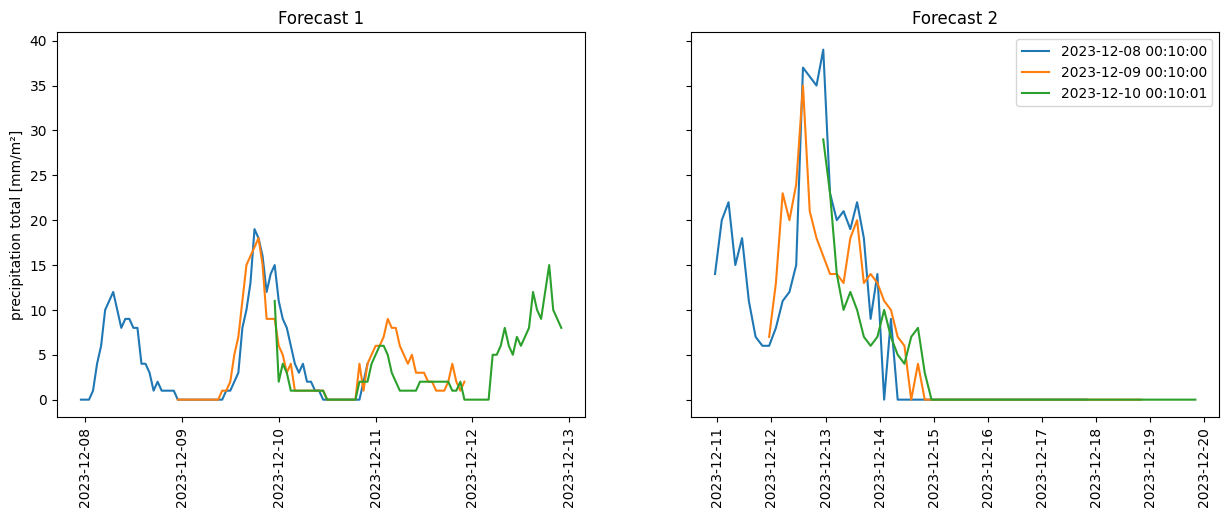

In [12]:
forecast1 = dataset_model_1.get_forecast(station_id=STATION_ID)
forecast2 = dataset_model_2.get_forecast(station_id=STATION_ID)


fig, axs = plt.subplots(ncols=2, sharey=True, figsize=DOUBLE_COL_FIG_SIZE)
for call_time in sorted(forecast1["call_time"].unique())[1:4]:
    sub_df_forecast = forecast1[forecast1["call_time"] == call_time]
    t = sub_df_forecast["time"]
    values = sub_df_forecast["precipitation_forecast"]
    axs[0].plot(t, values, label=call_time)
    
    sub_df_forecast = forecast2[forecast2["call_time"] == call_time]
    t = sub_df_forecast["time"]
    values = sub_df_forecast["precipitation_forecast"]
    axs[1].plot(t, values, label=call_time)

axs[0].set_xticks(axs[0].get_xticks(), axs[0].get_xticklabels(), rotation=90)
axs[0].set_title("Forecast 1")
axs[0].set_ylabel("precipitation total [mm/m²]")
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=90)
axs[1].set_title("Forecast 2")
axs[1].legend()

fig.savefig(FIG_SAVE_BASE_PATH + "precipitation_forecast.pdf")

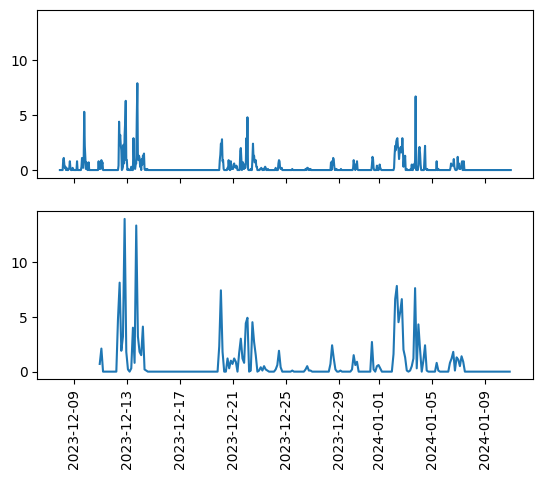

In [6]:


fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True)
real_data = dataset_model_1.get_merge(station_id=STATION_ID).sort_values(by="time")
axs[0].plot(real_data["time"], real_data["precipitation_real"])
real_data = dataset_model_2.get_merge(station_id=STATION_ID).sort_values(by="time")
axs[1].plot(real_data["time"], real_data["precipitation_real"])

axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=90)


Text(0.5, 0.98, 'Difference: Precipitation Forecast and Historical Precipitation for station: 257')

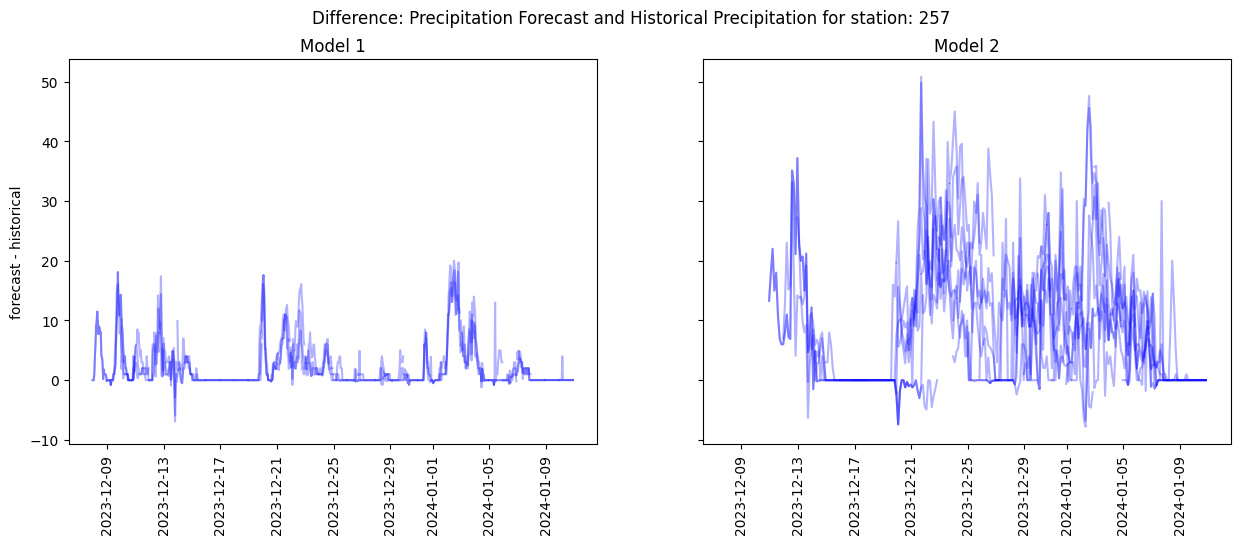

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=DOUBLE_COL_FIG_SIZE, sharey=True)
merge1 = dataset_model_1.get_merge(station_id=STATION_ID)
merge2 = dataset_model_2.get_merge(station_id=STATION_ID)

# fig, ax1 = plt.subplots()

api_call_times = sorted(merge1["call_time"].unique())
num_api_calls = len(api_call_times)
for idx, call_time in enumerate(api_call_times):
    sub_df_forecast = merge1[merge1["call_time"] == call_time]
    t = sub_df_forecast["time"]
    error = sub_df_forecast["precipitation_error"]
    ax1.plot(t, error, c="b", alpha=0.3)
    

    sub_df_forecast = merge2[merge2["call_time"] == call_time]
    t = sub_df_forecast["time"]
    error = sub_df_forecast["precipitation_error"]
    ax2.plot(t, error, c="b", alpha=0.3)
    
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)
ax1.set_ylabel("forecast - historical")
ax1.set_title("Model 1")
ax2.set_title("Model 2")
fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation for station: " + str(STATION_ID))

What is the general trend of the error in  model 1  and model 2

In [14]:
merge1 = dataset_model_1.get_merge()

call_times = sorted(merge1["call_time"].unique())
station_ids = sorted(merge1["station_id"].unique())
result = []
for call_time in call_times:
    call_time_result = []
    for station_id in station_ids:
        sub_df_forecast = merge1[(merge1["call_time"] == call_time) & (merge1["station_id"] == station_id)]
        
        if len(sub_df_forecast) < 72:
            continue
        call_time_result.append(sub_df_forecast["precipitation_error"].values[:72])
    
    if not call_time_result:
        continue
    result.append(np.stack(call_time_result))
error_mat_model_1 = np.stack(result)



In [15]:
merge2 = dataset_model_2.get_merge() 

call_times = sorted(merge2["call_time"].unique())
station_ids = sorted(merge2["station_id"].unique())
result = []
for call_time in call_times:
    call_time_result = []
    for station_id in station_ids:
        sub_df_forecast = merge2[(merge2["call_time"] == call_time) & (merge2["station_id"] == station_id)]
        
        if len(sub_df_forecast) < 56:  # 56 is how many samples are expected in a forecast of model 2
            continue
        call_time_result.append(sub_df_forecast["precipitation_error"][:56])
    
    if not call_time_result:
        continue
    result.append(np.stack(call_time_result))
error_mat_model_2 = np.stack(result)

(26, 36, 56)
coef:  [ 6.76510125 -0.07759605]


Text(0.5, 1.0, 'Model 2')

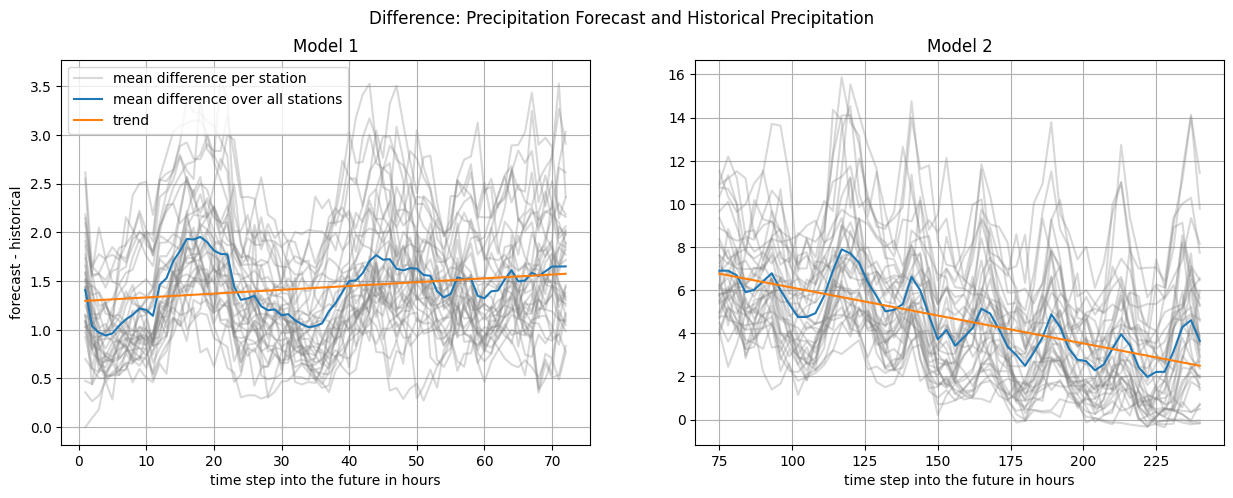

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=False)
fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation ")

# MODEL 1

station_errors = error_mat_model_1.mean(axis=0)
x_axis = np.arange(1, station_errors.shape[-1] + 1)

for idx, station_error in enumerate(station_errors):
    ax1.plot(x_axis, station_error, label="mean difference per station" if idx == 0 else "", color="grey", alpha=0.3)
forecast_error = station_errors.mean(axis=0)
ax1.plot(x_axis, forecast_error, label="mean difference over all stations")

# extract trend
x = np.arange(station_errors.shape[-1])[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
regression_coef = np.linalg.inv(x_aug.T @ x_aug) @ x_aug.T @ forecast_error
regression = x_aug @ regression_coef

ax1.plot(x_axis, regression, label="trend")

ax1.grid()
ax1.legend()
ax1.set_ylabel("forecast - historical")
ax1.set_title("Model 1")
ax1.set_xlabel("time step into the future in hours")


# MODEL 2
print(error_mat_model_2.shape)
station_errors = error_mat_model_2.mean(axis=0)
x_axis = (np.arange(1, station_errors.shape[-1] + 1) * 3) + 72

for idx, station_error in enumerate(station_errors):
    ax2.plot(x_axis, station_error, label="mean difference per station" if idx == 0 else "", color="grey", alpha=0.3)
forecast_error = station_errors.mean(axis=0)
ax2.plot(x_axis, forecast_error, label="mean difference over all stations")

# extract trend
x = np.arange(station_errors.shape[-1])[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
regression_coef = np.linalg.inv(x_aug.T @ x_aug) @ x_aug.T @ forecast_error
regression = x_aug @ regression_coef

ax2.plot(x_axis, regression, label="trend")

ax2.grid()
ax2.set_xlabel("time step into the future in hours")
print("coef: ", regression_coef)

ax2.set_title("Model 2")

# TODO: ask if we would use bar plots -> h

get confidence intervalls of the mean curve (blue) with bootstrap

In [41]:
# do bootstrapping for each time step into the future and therefor get a confidence internal around the mean error
N_BOOT = 10000

# MODEL 1

flatten_errors_1 = np.concatenate(error_mat_model_1, axis=0)
N_1 = len(flatten_errors_1)  # The idea is to draw random samples with replacement from the original dataset, and the sample size influences the variability of the estimates.
boot_strap_means_1 = np.empty((flatten_errors_1.shape[1], N_BOOT))

for idx, time_step_error in enumerate(tqdm(flatten_errors_1.T, desc="Bootstrap Model 1")):
    simulated_errors = np.random.choice(time_step_error, size=(N_BOOT, N_1), replace=True)
    mean_1 = simulated_errors.mean(axis=1)
    # print(boot_strap_means_1.shape, mean.shape)
    boot_strap_means_1[idx] = simulated_errors.mean(axis=1)
# MODEL 2

flatten_errors_2 = np.concatenate(error_mat_model_2, axis=0)
N_2 = len(flatten_errors_2)  # The idea is to draw random samples with replacement from the original dataset, and the sample size influences the variability of the estimates.
boot_strap_means_2 = np.empty((flatten_errors_2.shape[1], N_BOOT))

for idx, time_step_error in enumerate(tqdm(flatten_errors_2.T, desc="Bootstrap Model 2")):
    simulated_errors = np.random.choice(time_step_error, size=(N_BOOT, N_1), replace=True)
    mean_1 = simulated_errors.mean(axis=1)
    boot_strap_means_2[idx] = simulated_errors.mean(axis=1)


Bootstrap Model 2: 100%|██████████| 56/56 [00:04<00:00, 11.45it/s]


In [42]:
boot_strap_means_2.shape

(56, 10000)

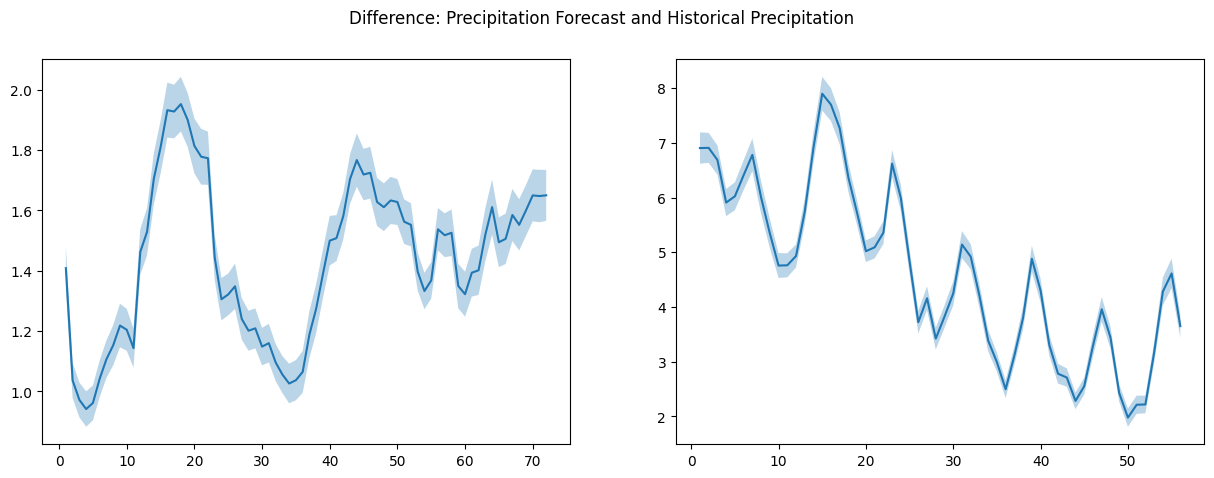

In [47]:

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=False)
fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation ")

x_axis = np.arange(1, 73)
mean_1 = boot_strap_means_1.mean(axis=1)
std_1 = boot_strap_means_1.std(axis=1)

ax1.plot(x_axis, mean_1)
ax1.fill_between(x_axis, mean_1 - std_1, mean_1 + std_1, alpha=0.3)


x_axis = np.arange(1, 57)
mean_2 = boot_strap_means_2.mean(axis=1)
std_2 = boot_strap_means_2.std(axis=1)

ax2.plot(x_axis, mean_2)
ax2.fill_between(x_axis, mean_2 - std_2, mean_2 + std_2, alpha=0.3)

# TODO: ellipse plots???? 


look at the covariance between the estimated mean and the estimated standard variance. 

[[153.3365245    7.98894878]
 [  7.98894878   0.41968375]]
[[1338.92084319   61.46071236]
 [  61.46071236    2.90414564]]


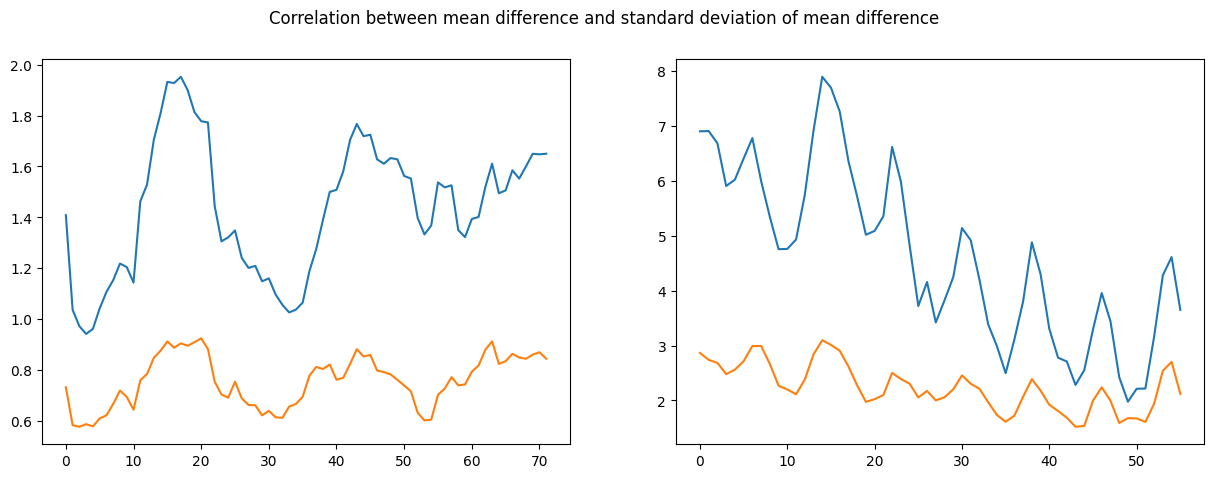

In [52]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=False)
fig.suptitle("Correlation between mean difference and standard deviation of mean difference")


ax1.plot(mean_1)
ax1.plot(std_1 * 10)

estimator_properties = np.stack([mean_1, std_1]).T
print(estimator_properties.T @ estimator_properties)

ax2.plot(mean_2)
ax2.plot(std_2 * 10)

estimator_properties = np.stack([mean_2, std_2]).T
print(estimator_properties.T @ estimator_properties)

IS one location espacially prone for errors?

Compute correlation between error and time to forecast?
Can we observe the same thing for temperature?

Can we do somehow bootstrapping?


given the amount of predicted precipitation whats the expected error 

Compute on average divergence for a forecast into the future. 
Observer how a forecast changes over time

